In [1]:
import numpy
%matplotlib inline
from matplotlib import pyplot

In [2]:
import sys
sys.path.append('../scripts/')

# Our helper
from plot_helper import *

In the previous notebook, we visually explained what are eigenvectors and eigenvalues, and we can use `numpy.linalg.eig` to solve for the eigenpairs. Take $\,A = \begin{bmatrix} 1 & 0 \\ 1 & 3 \end{bmatrix}$ as an example.

In [3]:
A = numpy.array([[1,0], [1,3]])
D, C = numpy.linalg.eig(A)
print(C)

[[ 0.          0.89442719]
 [ 1.         -0.4472136 ]]


$D$ is an array of eigenvalues and each column of $C$ represents a normalized eigenvector of matrix $A$. Let us draw both eigenvectors along with this linear transformation.

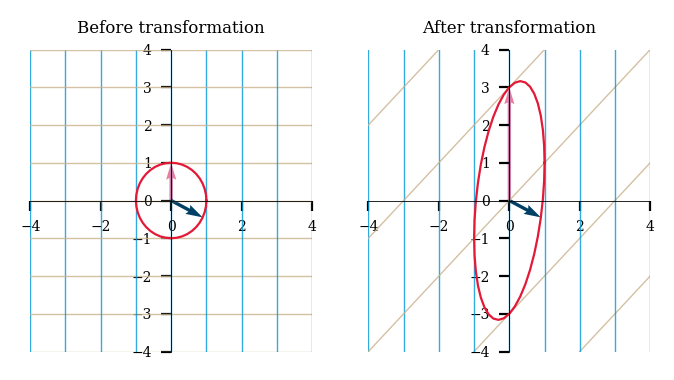

In [4]:
plot_linear_transformation(A, C[:,0], C[:,1], unit_vector=False, unit_circle=True)

We observed that the eigenvectors of a matrix $A$ will not change their directions after the transformation, therefore, they are considered very special to $A$. Besides, since the matrix $A$ transforms a unit circle into an ellipse, there is another interesting pair of vectors -  the vectors on the major and minor axis of this ellipse. They are intriguing because they are most stretched and most shrunk vectors after the transformation. Let us find them first.

In [31]:
alpha = numpy.linspace(0, 2*numpy.pi, 201)
circle = numpy.vstack((numpy.cos(alpha), numpy.sin(alpha)))
ellipse = A @ circle    # 2 by 41 ndarray
distance = numpy.linalg.norm(ellipse, axis=0)
major_id = numpy.argmax(distance)
minor_id = numpy.argmin(distance)
major = ellipse[:, major_id]
minor = ellipse[:, minor_id]
print(major, numpy.linalg.norm(major))
print(minor, numpy.linalg.norm(minor))

[0.33873792 3.16138023] 3.1794761076254896
[-0.94088077  0.07533299] 0.943891774007311


Recall that `major` and `minor` are transformed vectors which had a unit length before the transformation. To use our plotting function `plot_linear_transformation` to visualize them, we need to pass in the corresponding `major` and `minor` vectors before the transformation.

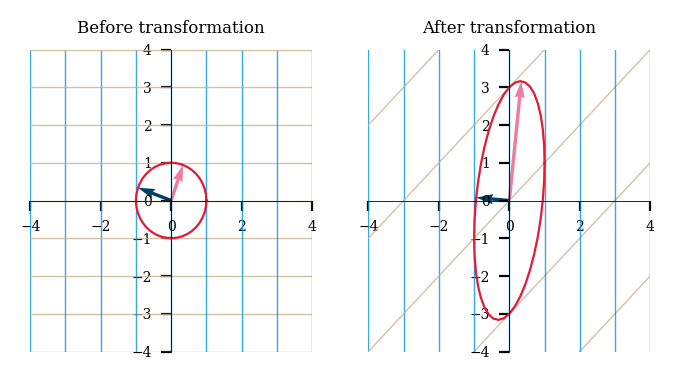

In [32]:
A_inv = numpy.linalg.inv(A)
major_before = A_inv @ major
minor_before = A_inv @ minor
plot_linear_transformation(A, major_before, minor_before, unit_vector=False, unit_circle=True)

We all know that the major and minor axes of an ellipse are orthogonal (perpendicular to each other), however, to our surprise, their corresponding vectors landing on the original unit circle appear to be orthogonal as well. Use inner product to confirm.

In [43]:
print(major.dot(minor))
print(major_before.dot(minor_before))

-0.08055576420695432
1.1102230246251565e-16


In [41]:
U, S, VT = numpy.linalg.svd(A)

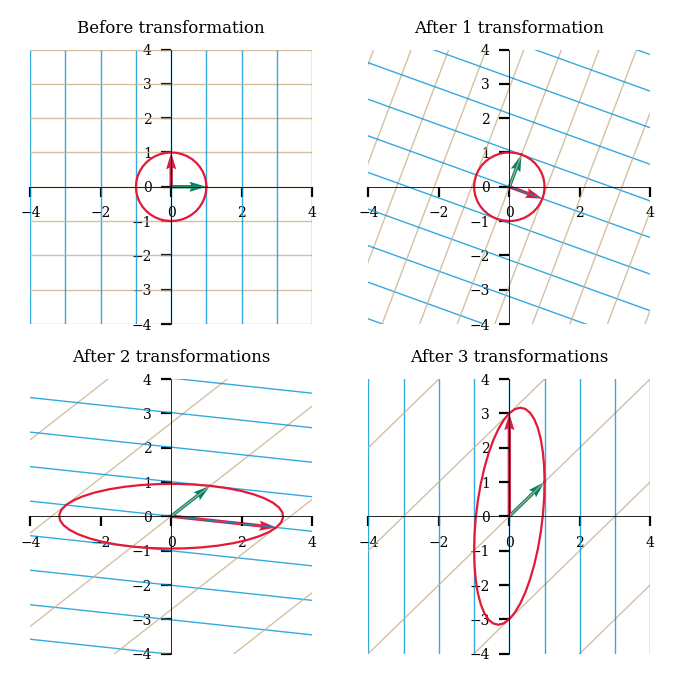

In [42]:
plot_linear_transformations(VT, numpy.diag(S), U, unit_circle='on')